# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import asc, col, datediff, dayofmonth, desc, from_unixtime
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType, IntegerType, StringType


%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1591898910186'),
 ('spark.driver.port', '36879'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'mint.lan'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Data

In [4]:
file_path = "./mini_sparkify_event_data.json"
df = spark.read.json(file_path)

## Clean Data

### Explore Data

In [5]:
# display columns names
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# size of the data
df.count(), len(df.columns)

(286500, 18)

In [7]:
# display first 5 record
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

### Clean Data

In [8]:
# make sure we dont have missing values 
df.filter("sessionId is null or userID is null").show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# remove data where userID is empty string
df = df.filter("userId != ''")

In [10]:
# shape of cleaned data
df.count(), len(df.columns)

(278154, 18)

# Exploratory Data Analysis



##  Define Churn

In [11]:
# list of events in page column
df.select("page").distinct().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



We will use the `Cancellation Confirmation` event in the `page` column to define churn, which happen for both paid and free users.

In [12]:
def get_churn(df=df):
    df.createOrReplaceTempView("df")
    # query a table with churned userId and value 1 indicating they are churned user
    churned_userId = spark.sql(
        'SELECT DISTINCT userId, 1 as churn FROM df \
    WHERE page = "Cancellation Confirmation"'
    )
    # query a table with churned userId and value 0 indicating they are churned user
    unchurned_userId = spark.sql(
        'SELECT DISTINCT userId, 0 as churn FROM df \
    WHERE userId NOT IN (SELECT DISTINCT userId from df WHERE Page = "Cancellation Confirmation")'
    )
    # merge two table together
    return churned_userId.union(unchurned_userId)

assert get_churn(df).count() == df.select("userId").distinct().count()

Pie Chart for Churn and Unchurned Users

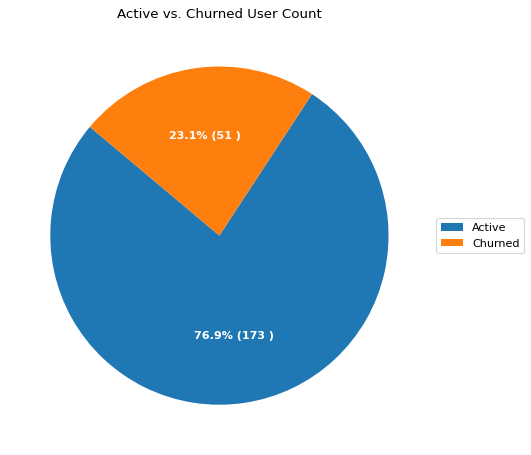

In [13]:
churn_df = get_churn(df).toPandas()
temp_df = churn_df.groupby('churn').size().reset_index(name='counts')
data = temp_df["counts"]

# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi=80)

def func(pct, allvals):
    """
    Helper funtion to generate text label for percentage and absolute counts
    """
    absolute = int(pct / 100.0 * np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)


wedges, texts, autotexts = ax.pie(
    data,
    autopct=lambda pct: func(pct, data),
    textprops=dict(color="w"),
    startangle=140,
)

# Decoration
ax.legend(
    wedges, ["Active", "Churned"], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Active vs. Churned User Count")
plt.show()

## User Life Time 

In [14]:
def get_days_since_reg(df=df):
    """
    Returns the number of days since registration for each user
    """
    
    min_ts = df.groupby("userId").agg(Fmin("registration"))
    max_ts = df.groupby("userId").agg(Fmax("ts"))
    ts_df = min_ts.join(max_ts, ["userId"])
    time_df = ts_df.select(
        col("userId"),
        from_unixtime(col("min(registration)") / 1000.0).alias("registration_time"),
        from_unixtime(col("max(ts)") / 1000.0).alias("last_active_time"),
    )
    return time_df.withColumn(
        "days_since_reg", datediff(col("last_active_time"), col("registration_time"))
    ).select("userId", "days_since_reg")
assert df.select("userId").distinct().count() == get_days_since_reg(df).count()

In [15]:
life_df= get_days_since_reg(df).toPandas()
temp_df =life_df.set_index("userId").join(churn_df.set_index("userId"))

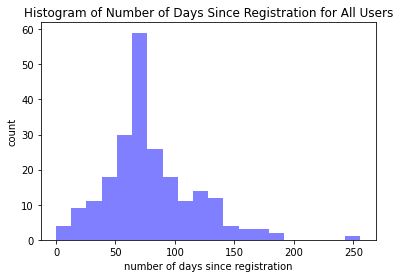

In [16]:
# histogram of number of days since registration for all users

num_bins = 20

x = temp_df["days_since_reg"]
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.title("Histogram of Number of Days Since Registration for All Users")
plt.xlabel("number of days since registration")
plt.ylabel("count")
plt.show()

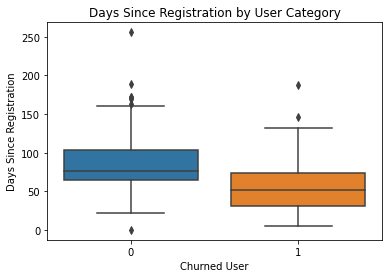

In [17]:
ax = sns.boxplot(x="churn", y="days_since_reg", data = temp_df)
ax.set_title("Days Since Registration by User Category")
ax.set_xlabel("Churned User")
ax.set_ylabel("Days Since Registration");

## User Gender

In [33]:
def get_gender(df = df):
    """
    Queary and returns the gender of each user
    """ 
    
    gender_df = df.groupby("userId").agg(Fmax("gender").alias('gender'))
    
    return gender_df

In [37]:
gender_df =get_gender(df).toPandas()
temp_df =gender_df.set_index("userId").join(churn_df.set_index("userId"))

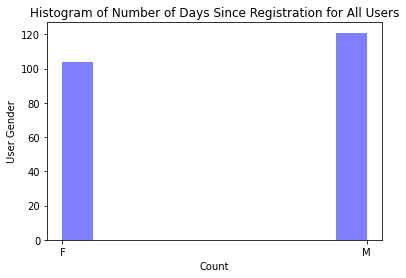

In [43]:
x = temp_df["gender"]
n, bins, patches = plt.hist(x, facecolor = 'blue', alpha = 0.5)
plt.title("Histogram of Number of Days Since Registration for All Users")
plt.xlabel("Count")
plt.ylabel("User Gender")
plt.show()

In [41]:
x

userId
100010    F
200002    M
125       M
124       F
51        M
         ..
45        F
57        M
200021    F
119       F
100001    F
Name: gender, Length: 225, dtype: object

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.